# [Project 3: Implementing a Simple Recurrent Neural Network (RNN)](https://github.com/jcp-tech/Seneca_Class_Notes/blob/master/Semester%202/AIG220%20-%20Deep%20Learning/Projects/Project%203/Project_3.ipynb)

## Introduction

In this project, you will design, implement, and evaluate a simple Recurrent Neural Network (RNN) from scratch. This will involve building the entire pipeline, from data preprocessing to model training and evaluation.

## Objectives

1. Set up TensorFlow or PyTorch environments. You are free to choose your preferred DL platform.
2. Use GPU for training.
3. Create a data loader and implement data preprocessing where needed.
4. Design a Recurrent Neural Network.
5. Train and evaluate your model. Make sure to clearly show loss and accuracy values. Include visualizations too.
6. Answer assessment questions.

<!--
## Dataset

You are free to choose any dataset for this project! Kaggle would be a good source to look for datasets. Below are some examples:
- Daily Minimum Temperatures in Melbourne: This dataset contains the daily minimum temperatures in Melbourne, Australia, from 1981 to 1990.
- Daily Bitcoin Prices: This dataset contains historical daily prices of Bitcoin, which can be used for time series forecasting projects.
- Text8 Dataset: This dataset consists of the first 100 million characters from Wikipedia. It's great for text generation or language modeling tasks.
- IMDB Movie Reviews: This dataset contains 50,000 movie reviews for sentiment analysis, split evenly into 25,000 training and 25,000 test sets.
- Jena Climate Dataset: This dataset records various weather attributes (temperature, pressure, humidity, etc.) every 10 minutes, making it ideal for time series analysis.
- Earthquake Aftershocks: This dataset contains seismic data, suitable for predicting aftershocks following major earthquakes.
-->

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os, sys, kagglehub, warnings
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, SimpleRNN
print(tf.__version__)
warnings.filterwarnings('ignore')

2.18.0


In [38]:
gpu_available = tf.config.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available and detected.")
    print(gpu_available)
else:
    print("No GPU detected. TensorFlow will use the CPU.")
    sys.exit("Exiting: No GPU found.")

GPU is available and detected.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [39]:
path = kagglehub.dataset_download("rccrea/daily-minimum-temperature-in-melbourne")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/daily-minimum-temperature-in-melbourne


In [40]:
csv_file = os.path.join(path, 'daily-min-temperatures.csv')
try:
    df = pd.read_csv(csv_file)
except FileNotFoundError:
    sys.exit(f"Error: The file {csv_file} was not found. Please check the file name and path.")
except Exception as e:
    sys.exit(f"An error occurred while loading the dataset: {e}")
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3650 non-null   object 
 1   Temp    3650 non-null   float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


In [42]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [43]:
## We Do Scalling to Standarise the Temp Data from Range of 0-1.
### Scale the temperature data to the range [0, 1] using Min-Max normalization.
### This helps improve model performance and training stability in neural networks.
scaler = MinMaxScaler(feature_range=(0, 1)) # Scale the temperature data
scaled_data = scaler.fit_transform(df['Temp'].values.reshape(-1, 1))
print("Scaled data =")
for idx in range(5):
    print(f"Original: {df['Temp'].values[idx]}, Scaled: {scaled_data[idx][0]}")

Scaled data =
Original: 20.7, Scaled: 0.7870722433460076
Original: 17.9, Scaled: 0.6806083650190113
Original: 18.8, Scaled: 0.714828897338403
Original: 14.6, Scaled: 0.5551330798479087
Original: 15.8, Scaled: 0.6007604562737643


In [44]:
## We Do Scaling to Normalize the Temperature Data to the Range [0, 1]
### Scale the temperature data to the range [0, 1] using Min-Max normalization.
### This ensures all input values are on the same scale, which improves model performance, speeds up convergence, and helps prevent issues caused by differing value ranges.
def create_sequences(data, sequence_length):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

sequence_length = 10
X, y = create_sequences(scaled_data, sequence_length)

print(f"\nShape of input sequences (X): {X.shape}")  # (samples, timesteps, features)
print(f"Shape of target values (y): {y.shape}")     # (samples,)

# Show sample input and target
print("\nFirst input sequence:")
print(X[0])
print("\nFirst target value:")
print(y[0])


Shape of input sequences (X): (3640, 10, 1)
Shape of target values (y): (3640, 1)

First input sequence:
[[0.78707224]
 [0.6806084 ]
 [0.7148289 ]
 [0.5551331 ]
 [0.60076046]
 [0.60076046]
 [0.60076046]
 [0.66159695]
 [0.82889736]
 [0.76045626]]

First target value:
[0.6159696]


In [45]:
# Train-test split (time series: NO shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Output final shapes
print(f"\nTraining data shape (X_train): {X_train.shape}")
print(f"Training data shape (y_train): {y_train.shape}")
print(f"Testing data shape (X_test): {X_test.shape}")
print(f"Testing data shape (y_test): {y_test.shape}")


Training data shape (X_train): (2912, 10, 1)
Training data shape (y_train): (2912, 1)
Testing data shape (X_test): (728, 10, 1)
Testing data shape (y_test): (728, 1)


In [46]:
def build_rnn_model(cell_type, units=100, dropout=0.2, sequence_length=10, input_dim=1):
    model = Sequential()
    # Choose RNN cell type
    if cell_type == 'LSTM':
        model.add(LSTM(units=units, activation='relu', input_shape=(sequence_length, input_dim)))
        # model.add(Dropout(dropout)) # Expirmenting with more Layers
        # model.add(LSTM(units=units//2, activation='relu')) # Expirmenting
    elif cell_type == 'GRU':
        model.add(GRU(units=units, activation='relu', input_shape=(sequence_length, input_dim)))
    elif cell_type == 'SimpleRNN':
        model.add(SimpleRNN(units=units, activation='relu', input_shape=(sequence_length, input_dim)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

models_to_run = ['LSTM', 'GRU', 'SimpleRNN']

trained_models = {}
histories = {}
results = {}

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
actual_temperatures = scaler.inverse_transform(y_test.reshape(-1, 1))
# actual_temperatures

In [47]:
for model_name in models_to_run:
    print(f"\n\nTraining {model_name} model...")
    model = build_rnn_model(
        cell_type=model_name,
        units=100,
        dropout=0.2,
        sequence_length=sequence_length,
        input_dim=1
    )
    model.summary()
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    predictions = model.predict(X_test)
    trained_models[model_name] = model
    histories[model_name] = history
    predicted_temperatures = scaler.inverse_transform(predictions)
    results[model_name] = {
        'test_loss': test_loss,
        'test_mae': test_mae,
        # 'predictions': predictions,
        'predicted_temperatures': predicted_temperatures,
        'rmse': np.sqrt(mean_squared_error(actual_temperatures, predicted_temperatures)),
        'mae': mean_absolute_error(actual_temperatures, predicted_temperatures)
    }



Training LSTM model...


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0856 - mean_absolute_error: 0.2356 - val_loss: 0.0111 - val_mean_absolute_error: 0.0808
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0142 - mean_absolute_error: 0.0952 - val_loss: 0.0107 - val_mean_absolute_error: 0.0795
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - mean_absolute_error: 0.0922 - val_loss: 0.0111 - val_mean_absolute_error: 0.0812
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129 - mean_absolute_error: 0.0893 - val_loss: 0.0104 - val_mean_absolute_error: 0.0786
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0121 - mean_absolute_error: 0.0862 - val_loss: 0.0112 - val_mean_absolute_error: 0.0816
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0120 - mean_absolute_error: 0.0864 - val_loss: 0.0103 - val_mean_absolute_error: 0.0779
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - mean_absolute_error: 0.0894 - val_los

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 100)            │        30,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,001 (121.10 KB)

 Trainable params: 31,001 (121.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0741 - mean_absolute_error: 0.2125 - val_loss: 0.0110 - val_mean_absolute_error: 0.0807
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - mean_absolute_error: 0.0908 - val_loss: 0.0105 - val_mean_absolute_error: 0.0791
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - mean_absolute_error: 0.0889 - val_loss: 0.0097 - val_mean_absolute_error: 0.0757
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123 - mean_absolute_error: 0.0869 - val_loss: 0.0096 - val_mean_absolute_error: 0.0754
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0118 - mean_absolute_error: 0.0859 - val_loss: 0.0099 - val_mean_absolute_error: 0.0769
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0119 - mean_absolute_error: 0.0853 - val_loss: 0.0101 - val_mean_absolute_error: 0.0780
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0118 - mean_absolute_error: 0.0850 - val_los

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 100)            │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,301 (40.24 KB)

 Trainable params: 10,301 (40.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0623 - mean_absolute_error: 0.1890 - val_loss: 0.0097 - val_mean_absolute_error: 0.0759
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - mean_absolute_error: 0.0889 - val_loss: 0.0094 - val_mean_absolute_error: 0.0748
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0126 - mean_absolute_error: 0.0893 - val_loss: 0.0090 - val_mean_absolute_error: 0.0732
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - mean_absolute_error: 0.0853 - val_loss: 0.0090 - val_mean_absolute_error: 0.0736
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0117 - mean_absolute_error: 0.0852 - val_loss: 0.0088 - val_mean_absolute_error: 0.0731
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0113 - mean_absolute_error: 0.0839 - val_loss: 0.0091 - val_mean_absolute_error: 0.0742
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0109 - mean_absolute_error: 0.0819 - val_los

In [48]:
# Calculate the average difference between actual and predicted temperatures for each model
print("\nGeneral Temperature Difference (Average Absolute Difference) for each model:")
for model_name, result in results.items():
    predicted_temps = result['predicted_temperatures']
    actual_temps = actual_temperatures # This was already computed before the loop
    average_diff = np.mean(np.abs(predicted_temps - actual_temps))
    print(f"\nModel Performance of '{model_name}' =")
    print(f"Average Absolute Difference - {average_diff:.4f}")
    print(f"Test Loss (MSE): {result['test_loss']:.4f}")
    print(f"Test MAE: {result['test_mae']:.4f}")
    print(f"RMSE: {result['rmse']:.4f}")
    print(f"MAE: {result['mae']:.4f}")


General Temperature Difference (Average Absolute Difference) for each model:

Model Performance of 'LSTM' =
Average Absolute Difference - 1.7589
Test Loss (MSE): 0.0073
Test MAE: 0.0669
RMSE: 2.2520
MAE: 1.7589

Model Performance of 'GRU' =
Average Absolute Difference - 1.7380
Test Loss (MSE): 0.0070
Test MAE: 0.0661
RMSE: 2.2019
MAE: 1.7380

Model Performance of 'SimpleRNN' =
Average Absolute Difference - 1.7236
Test Loss (MSE): 0.0070
Test MAE: 0.0655
RMSE: 2.1960
MAE: 1.7236



Results for LSTM:


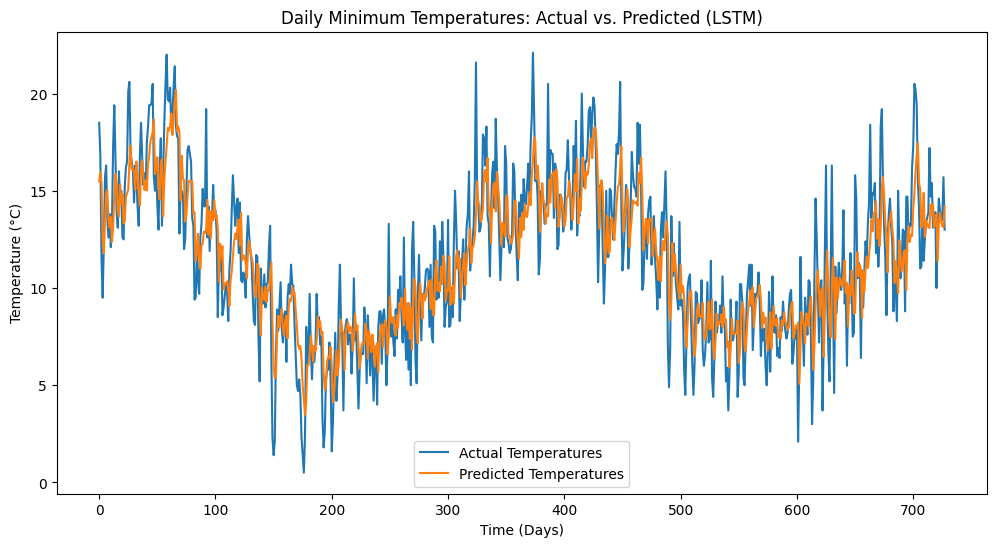


Results for GRU:


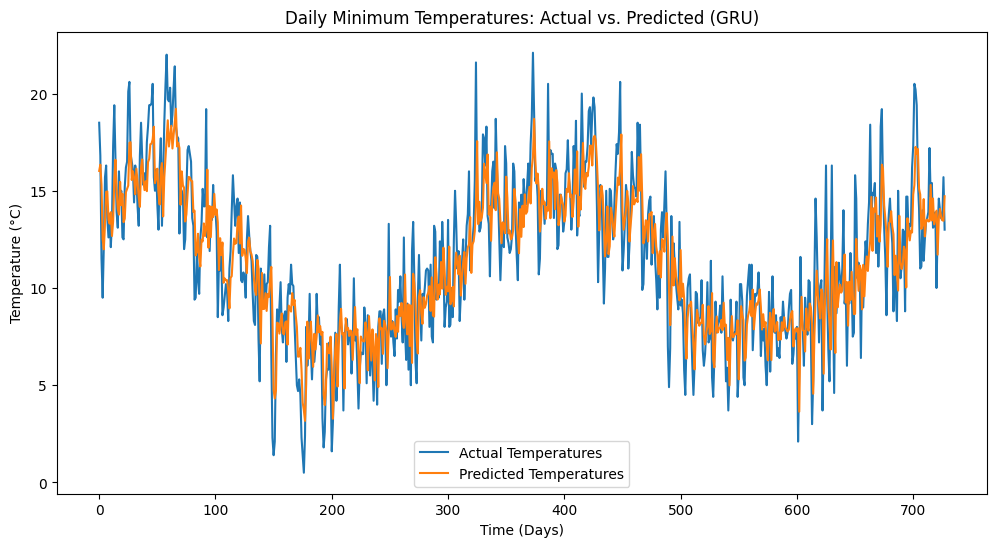


Results for SimpleRNN:


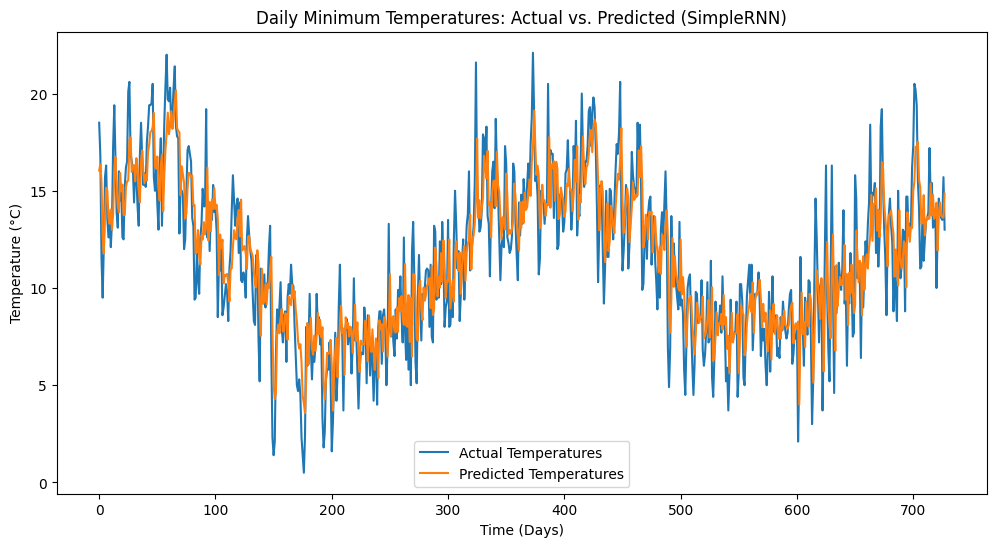

In [49]:
def visualize_results(actual_temperatures, predicted_temperatures, model_name):
  # Visualize the results
  plt.figure(figsize=(12, 6))
  plt.plot(actual_temperatures, label='Actual Temperatures')
  plt.plot(predicted_temperatures, label='Predicted Temperatures')
  plt.title(f'Daily Minimum Temperatures: Actual vs. Predicted ({model_name})')
  plt.xlabel('Time (Days)')
  plt.ylabel('Temperature (°C)')
  plt.legend()
  plt.show()

for model_name, result in results.items():
    print(f"\nResults for {model_name}:")
    visualize_results(actual_temperatures, result['predicted_temperatures'], model_name)


Training history for LSTM:


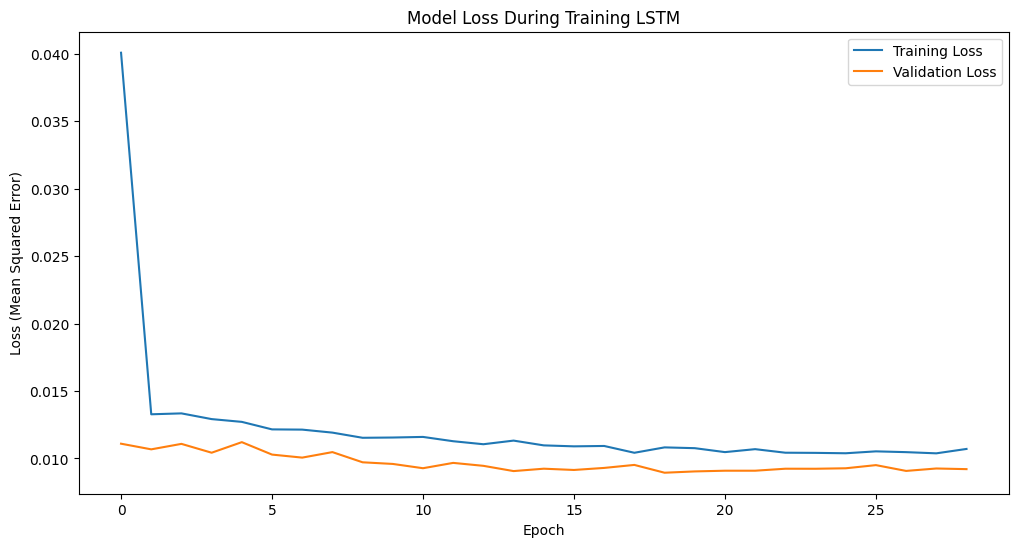


Training history for GRU:


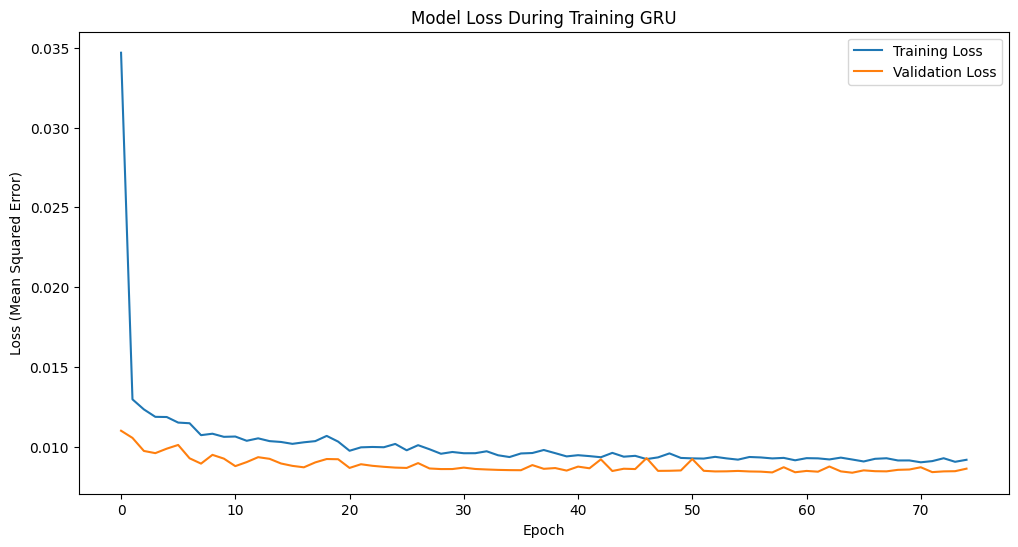


Training history for SimpleRNN:


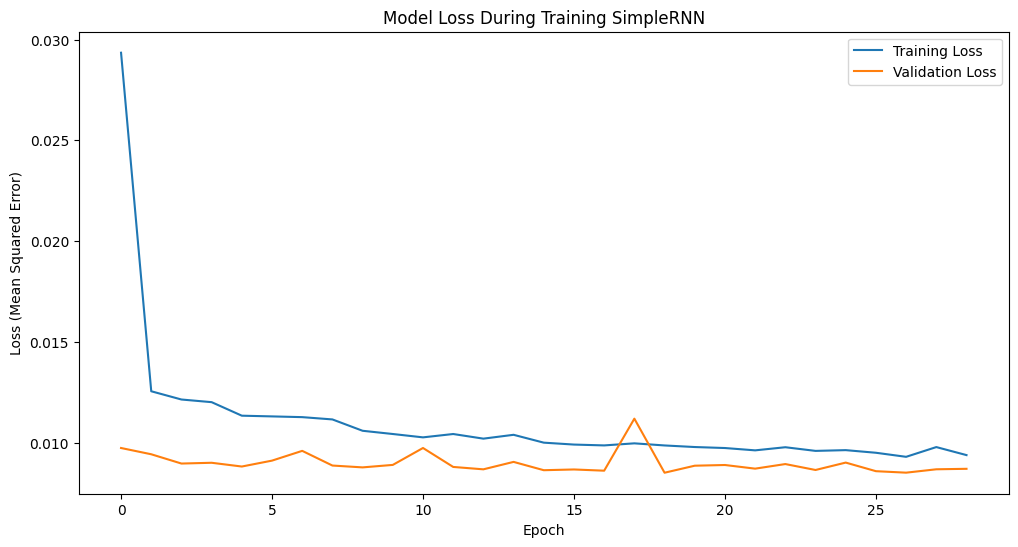

In [52]:
# Visualize the training history (loss)
def plot_training_history(history, model_name):
  plt.figure(figsize=(12, 6))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title(f'Model Loss During Training {model_name}')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (Mean Squared Error)')
  plt.legend()
  plt.show()

for model_name, history in histories.items():
    print(f"\nTraining history for {model_name}:")
    plot_training_history(history, model_name)

---
## Questions & Answers

### 1. What is a Recurrent Neural Network (RNN)? Describe its key components and how they differ from those in a feedforward neural network.

A **Recurrent Neural Network (RNN)** is a type of neural network designed for processing sequential data. The key feature of an RNN is its ability to maintain a **hidden state** that carries information from previous time steps, enabling it to model dependencies across sequences.

**Key components:**

* **Input Layer:** Accepts sequence data one timestep at a time.
* **Recurrent/Hidden Layer:** Contains neurons with self-connections. The output at each time step depends on both the current input and the previous hidden state.
* **Output Layer:** Produces predictions for each timestep or the final output.

**Difference from Feedforward Neural Networks:**

* Feedforward networks process each input independently, while RNNs have loops that allow information to persist, making them suitable for sequences where order matters (e.g., language, time series).

### 2. Explain the purpose of the recurrent connection in an RNN. How does it enable the network to handle sequential data?

The **recurrent connection** in an RNN feeds the hidden state from the previous timestep back into the network at the next timestep. This allows the RNN to **retain memory** of previous inputs and model temporal or sequential dependencies. Because of this feedback loop, RNNs can learn patterns over time and handle tasks where the context of previous data points is important (such as predicting the next word in a sentence or the next value in a time series).

### 3. What are vanishing and exploding gradients, and how do they affect the training of RNNs?

**Vanishing gradients** occur when gradients shrink exponentially as they are propagated backward through time, making it hard for the network to learn long-range dependencies. **Exploding gradients** occur when gradients grow exponentially, causing unstable updates and potentially diverging weights.

**Effect on RNNs:**

* **Vanishing gradients:** Prevent RNNs from learning long-term dependencies, as updates to earlier layers become negligibly small.
* **Exploding gradients:** Cause large parameter updates that can destabilize training.

### 4. Describe the Long Short-Term Memory (LSTM) network and its key components. How does it address the issues of vanishing and exploding gradients?

An **LSTM** is a specialized RNN architecture designed to better capture long-range dependencies. It contains a memory cell and three gates:

* **Input gate:** Controls how much new information enters the cell.
* **Forget gate:** Controls what information to discard from the cell.
* **Output gate:** Controls what information is output from the cell.

**How LSTM addresses vanishing/exploding gradients:**

* The memory cell allows gradients to flow unchanged over many timesteps, reducing the vanishing gradient problem. The gates provide controlled, differentiable paths for information and gradients, making learning long-term dependencies feasible and stabilizing training.

### 5. What is the purpose of the GRU (Gated Recurrent Unit) in RNNs? Compare it with LSTM.

A **GRU** is a simpler alternative to LSTM, designed to capture long-term dependencies with fewer parameters and less computational cost. It merges the forget and input gates into a single **update gate** and combines the cell state and hidden state.

**Comparison:**

* **LSTM:** Has three gates (input, forget, output) and a separate cell state.
* **GRU:** Has two gates (reset, update) and merges cell and hidden states.
* **GRU is generally faster to train, but LSTMs may perform better on tasks requiring learning very long-term dependencies.**

### 6. Explain the role of the hidden state in an RNN. How is it updated during the training process?

The **hidden state** is the RNN's internal memory, capturing information about previous inputs in the sequence. At each timestep, the hidden state is updated based on the current input and the previous hidden state using learned weights and activation functions (typically tanh or ReLU). During training, the weights are adjusted via backpropagation through time (BPTT) to minimize the loss.

### 7. What are some common evaluation metrics used to assess the performance of an RNN on a sequential task, such as language modeling or time series forecasting?

**Common metrics:**

* **Mean Squared Error (MSE):** Used for regression/time series forecasting.
* **Mean Absolute Error (MAE):** Another regression metric, more robust to outliers.
* **Root Mean Squared Error (RMSE):** Interpretable as the average prediction error.
* **Accuracy, Precision, Recall, F1-Score:** Used for classification tasks.
* **Perplexity:** Used for language modeling to measure how well a probability model predicts a sample.

### 8. How does data preprocessing impact the performance of RNNs? Provide examples of preprocessing steps for text and time series data.

**Impact:**
Preprocessing improves convergence, stability, and the ability of the model to learn relevant patterns by presenting the network with appropriately scaled and formatted data.

**Examples:**

* **Text:** Tokenization, lowercasing, removing punctuation, encoding words as sequences of integers, padding/truncating sequences, one-hot encoding, or word embeddings.
* **Time Series:** Normalization/scaling (e.g., MinMaxScaler), handling missing values, windowing/creating input sequences, and differencing to remove trends.

### 9. What is sequence-to-sequence learning in the context of RNNs, and what are its applications?

**Sequence-to-sequence (seq2seq) learning** refers to mapping an input sequence to an output sequence, possibly of different length. Typically implemented using an encoder-decoder architecture (both using RNNs or their variants).

**Applications:**

* Machine translation (e.g., English to French)
* Text summarization
* Speech recognition
* Conversational agents (chatbots)
* Time series prediction with variable-length outputs

### 10. How can RNNs be used for anomaly detection in time series data? Describe the general approach.

**General approach:**

* Train an RNN on normal (non-anomalous) time series data to predict the next value(s) in the sequence.
* During inference, use the trained RNN to make predictions.
* Calculate the prediction error (e.g., MAE or MSE) at each timestep.
* Flag a data point as an anomaly if the prediction error exceeds a predefined threshold, indicating the observed value is unusual compared to what the RNN has learned.


---
### Submission
Submit a link to your completed Jupyter Notebook (e.g., on GitHub (private) or Google Colab) with all the cells executed, and answers to the assessment questions included at the end of the notebook.